## Mixed-element Meshing - Toy Problem

This workflow provides a testbed for testing features of mixed-element mesh wotkflow. The objects of river tree and huc boundary are a created to mimic what we get from NHDPlus. This example tests the case of two rivers, which is rare but still needs to be considered to make the workflow general

In [1]:
## Importing all the package needed to run teh watershed workflow

import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging
import copy
import geopandas as gpd

In [2]:
import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.resampling
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)
crs=None

In [3]:
## NHDPlus input type objects

# creating watershed polygon
ws1 = shapely.geometry.Polygon(100*np.array([[0,0],[1,0],[2,0],[3,0],[4,0],[4,1],[4,2],[4,3],[4,4],[3,4.5],[2,5],[1,4.5], [0,4], [0,3], [0,2] ,[0,1]], 'd'))
my_hucs = gpd.GeoDataFrame()
my_hucs['geometry'] = [ws1,]

# creating reaches miminc NHDPlus flowlines
reach1=shapely.geometry.LineString([(200,200),(200,0)])
reach2=shapely.geometry.LineString([ (50,300), (100,300), (100,200),(200,200)])
reach3=shapely.geometry.LineString([ (350,400),(350,300),(300,300),(300,200),(200,200)])
reach4=shapely.geometry.LineString([(100,400), (200,300)])
reaches = gpd.GeoDataFrame()
reaches.geometry = [reach1, reach2, reach3, reach4]

In [4]:
# creating watershed_workflow.split_hucs.SplitHUCs object for demo watershed
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

2024-11-21 15:48:50,667 - root - INFO: Removing holes on 1 polygons
2024-11-21 15:48:50,667 - root - INFO:   -- removed interior
2024-11-21 15:48:50,668 - root - INFO:   -- union
2024-11-21 15:48:50,668 - root - INFO: Parsing 1 components for holes
2024-11-21 15:48:50,668 - root - INFO:   -- complete


In [5]:
rivers = watershed_workflow.river_tree.createRiverTrees(reaches, method='geometry')

rivers_orig=[river.deepcopy() for river in rivers] # mimicking the original
watershed_orig=copy.deepcopy(watershed) # keeping the original

# simplify the geometry for a "nicer" discrete object
watershed_workflow.simplify(watershed, rivers, simplify_rivers=10, cut_intersections=True)

# for plotting purpose
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2024-11-21 15:48:50,970 - root - INFO: 
2024-11-21 15:48:50,971 - root - INFO: Simplifying
2024-11-21 15:48:50,972 - root - INFO: ------------------------------
2024-11-21 15:48:50,972 - root - INFO: Simplifying rivers
2024-11-21 15:48:50,974 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-11-21 15:48:50,975 - root - INFO:   snapping polygon linestring boundaries to river endpoints
2024-11-21 15:48:50,976 - root - INFO:   snapping river endpoints to the polygon
2024-11-21 15:48:50,978 - root - INFO:   cutting at crossings
2024-11-21 15:48:50,978 - root - INFO: intersection found
2024-11-21 15:48:50,979 - root - INFO:   - cutting reach at external boundary of HUCs:
2024-11-21 15:48:50,979 - root - INFO:       split HUC boundary seg into 2 pieces
2024-11-21 15:48:50,979 - root - INFO:       split reach seg into 1 pieces
2024-11-21 15:48:50,980 - root - INFO: Cutting crossings and removing external linestrings
2024-11-21 15:48:50,980 - root - INFO:   cutting at crossi

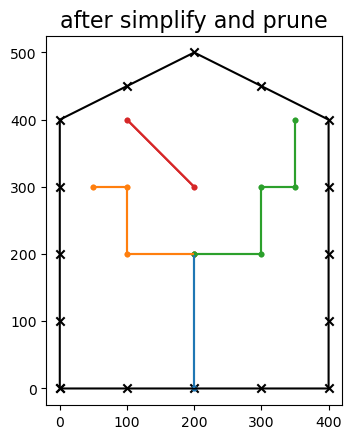

In [6]:
# quick glance at the problem
ax = watershed_simplified.plot(color='k', marker='x')
ax.set_title('after simplify and prune',fontsize=16)

for river in rivers_simplified:
    river.plot(marker='o',markersize=10, ax=ax)



In [8]:
# resample the watershed
river_mls = shapely.ops.unary_union([r.to_mls() for r in rivers])
strategy = watershed_workflow.resampling.createStrategyByDistance([0,25,100,50], river_mls)
watershed_workflow.resampling.resampleHUCs(watershed, strategy)
                                           

# resample the river
strategy2 = watershed_workflow.resampling.createStrategyFixed(14)
watershed_workflow.resampling.resampleRivers(rivers, strategy2)


In [9]:
# finding the outlet
watershed_workflow.hydrography.findOutletsByCrossings(watershed, rivers[0])

2024-11-21 15:51:38,975 - root - INFO: Crossings by Polygon:
2024-11-21 15:51:38,975 - root - INFO:   Polygon 0
2024-11-21 15:51:38,975 - root - INFO:     crossing: [200.   0.]
2024-11-21 15:51:38,975 - root - INFO: Constructing outlet list
2024-11-21 15:51:38,976 - root - INFO: Iteration = 0
2024-11-21 15:51:38,976 - root - INFO: -----------------
2024-11-21 15:51:38,976 - root - INFO:  poly outlet 0 : 0, [200.   0.]
2024-11-21 15:51:38,976 - root - INFO: last outlet is 0 in polygon 0 at [200.   0.]


Text(0.5, 1.0, 're-densified')

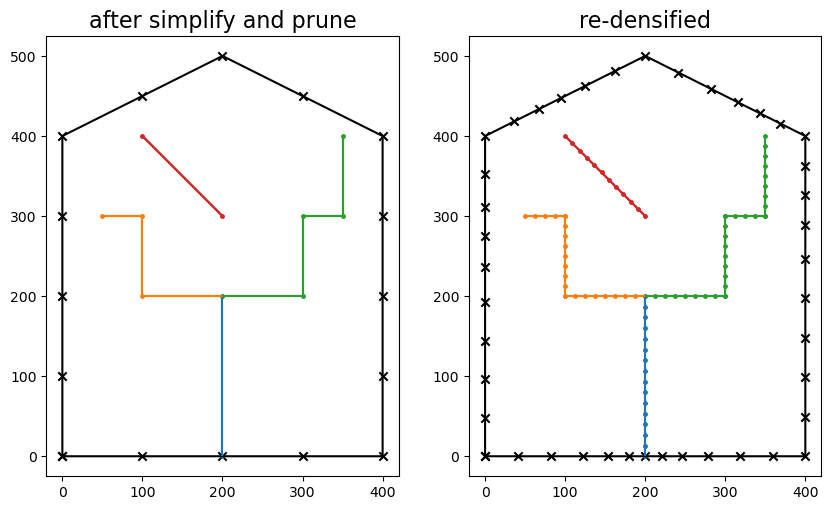

In [10]:
# plotting results
plt.rcParams['figure.figsize'] = [10, 6]
fig, axs = plt.subplots(1,2)

watershed_simplified.plot(color='k', marker='x', ax=axs[0])
for river in rivers_simplified:
    river.plot(marker='o', markersize=5, ax=axs[0])
axs[0].set_title('after simplify and prune',fontsize=16)


watershed.plot(color='k', marker='x', ax=axs[1])
for river in rivers:
    river.plot(marker='o', markersize=5, ax=axs[1])
axs[1].set_title('re-densified',fontsize=16)


# Meshing

In [10]:
## Triangulation
refine_d0 = 12
refine_d1 = 18
refine_A0 = 82
refine_A1 = 500
d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width) or integer
widths=5

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle,refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True)

AttributeError: module 'watershed_workflow' has no attribute 'tessalate_river_aligned'

In [ ]:
# providing elevations to each point of the mesh (real case this would come from DEMs)
points3=np.zeros((len(mesh_points2),3))
points3[:,:2]=mesh_points2
points3[:,2]=9+abs(mesh_points2[:,0]-200)/800+mesh_points2[:,1]/500 # gradient towards the outlet 

In [ ]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(points3.copy(), conn_list)

In [ ]:
# depressing river corridor
def condition_river_mesh(m2, river, depress_by):
    m2_copy=copy.deepcopy(m2)
    for node in river.preOrder():
        for i, elem in enumerate(node.elements):
            for j in range(len(elem)):
                m2.coords[elem[j]][2]=m2_copy.coords[elem[j]][2]-depress_by

In [ ]:
# adding depressions for the river
for river in rivers:
    condition_river_mesh(m2, river, 1)

In [ ]:
# plotting surface mesh with elevations
plt.rcParams['figure.figsize'] = [12, 15]
crs=None
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.8 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k',facecolor='color')

watershed_workflow.colors.colorbar_index(ncolors=len(legend_values), cmap=cmap, labels=labels, ax=ax) 
plt.title('Surface Mesh with Elevations')
plt.show()

### Mesh Extrusion

In [ ]:
## **** Creating a 3D mesh

# this is oversimplified case where we wille xtrude this mesh in 3D with 10 layers of prescribed thicknesses

total_thickness = 10
dzs=[0.1,0.2, 0.2, 0.25,0.25,0.25,0.25,1,1.25,1.25,2,3]
print(sum(dzs))
assert(sum(dzs)==total_thickness)

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

depth = 0
for dz in dzs:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1000)
  
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

In [ ]:
# # extrude
# m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2,layer_types, layer_data, 
#                                              layer_ncells, layer_mat_ids)

# # saving mesh as exodus file
# m3.write_exodus('demo_mixed_element_mesh.exo')